In [13]:

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
filename = 'cleaned_data.csv'
def load_and_explore_data(filename='cleaned_data.csv'):
    """Load the dataset and perform initial exploration"""

    # Load data
    df = pd.read_csv(filename)

    print(f"📊 Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

    # Convert date column
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Basic info about target variable
    target = 'Deep sleep (mins)'
    print(f"\n🎯 Target Variable: {target}")
    print(f"Mean: {df[target].mean():.1f} minutes")
    print(f"Std: {df[target].std():.1f} minutes")
    print(f"Range: {df[target].min():.0f} - {df[target].max():.0f} minutes")

    return df

df = load_and_explore_data()



UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 10: invalid start byte


🔍 CORRELATION ANALYSIS
----------------------------------------
🏆 Top correlations with Deep Sleep:
  Resting heart rate: -0.394
  Sleep score: 0.373
  Body Battery: 0.270
  REM sleep (mins): 0.229
  Duration (mins): 0.212
  Calories: -0.190
  Steps: -0.190
  Max HR: -0.174
  Minutes intense exercise: -0.125

📊 Creating correlation matrix with 31 variables...


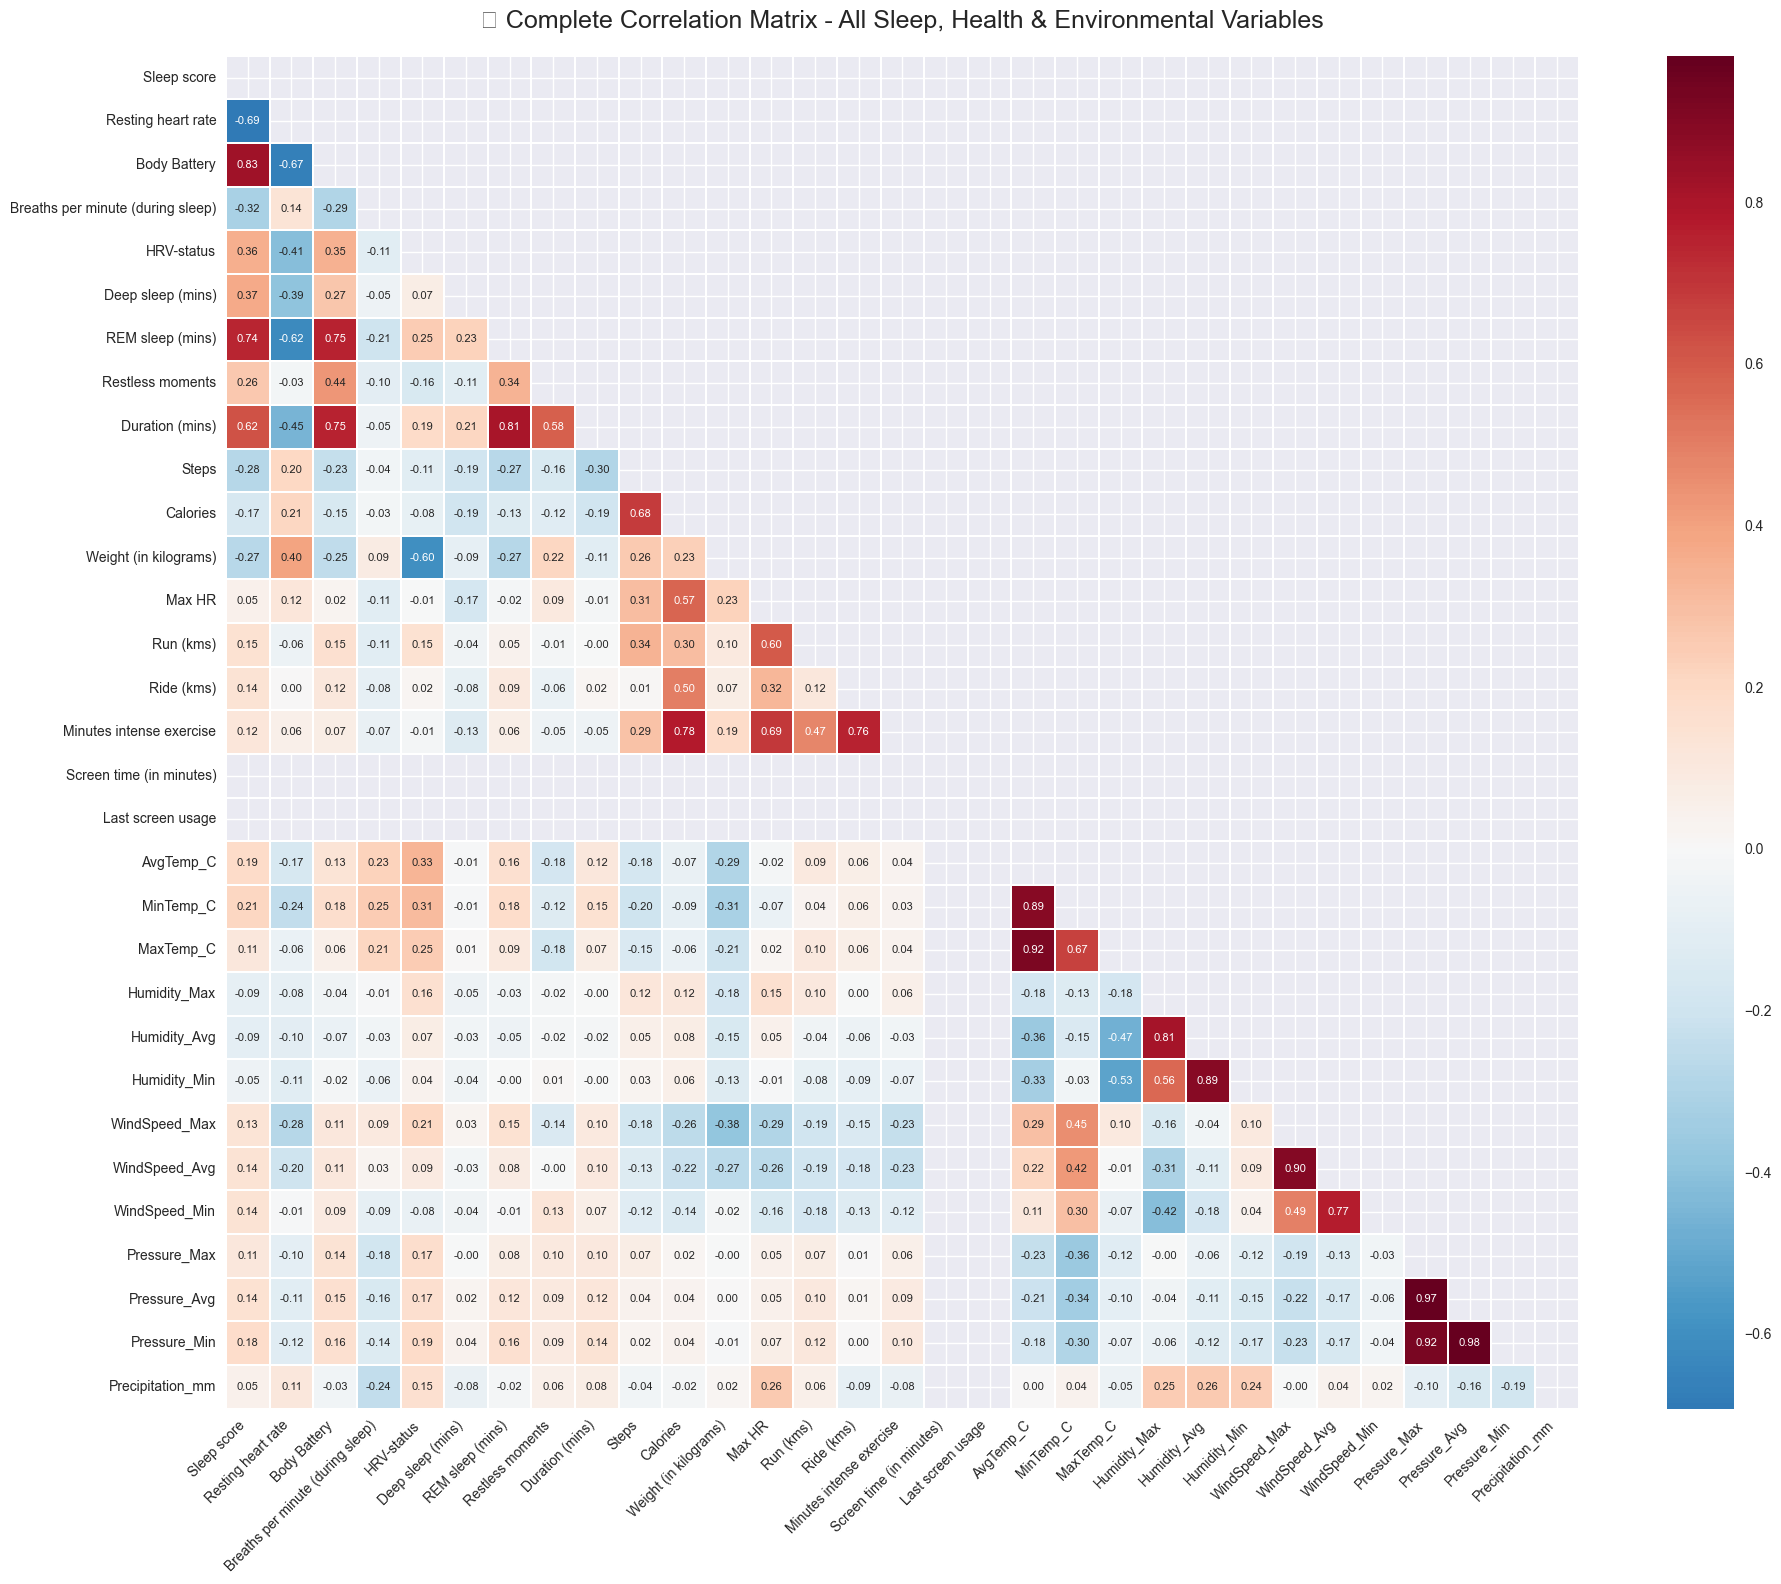

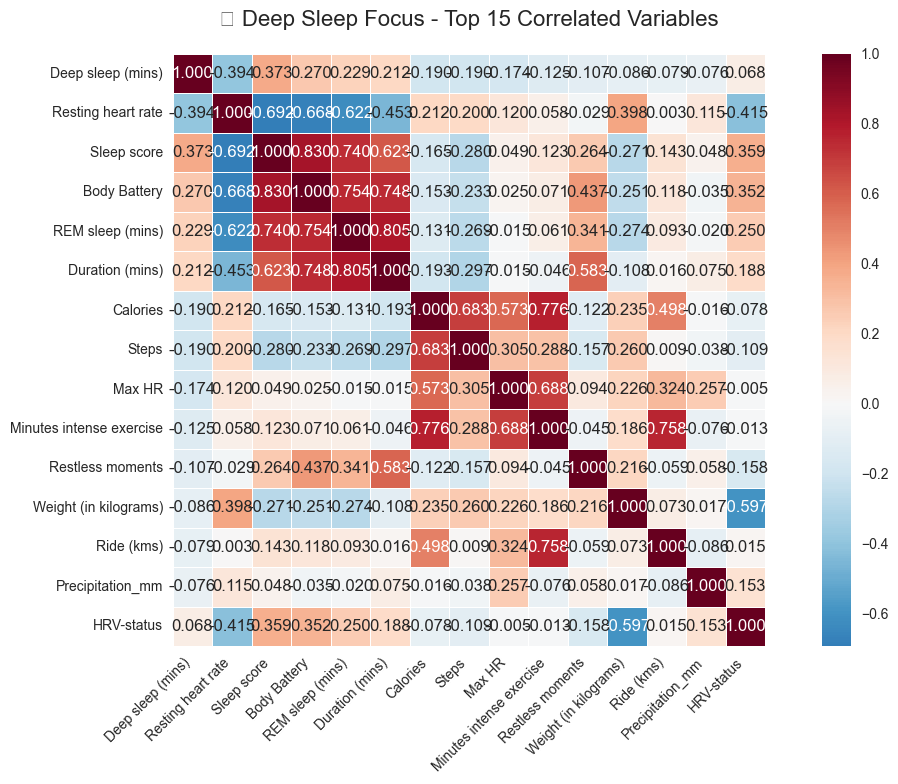

In [28]:
#Cor matrix
def create_correlation_analysis(df):
    """Create comprehensive correlation analysis"""

    print("\n🔍 CORRELATION ANALYSIS")
    print("-" * 40)

    # Select numeric columns for correlation (excluding outlier indicators)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    core_cols = [col for col in numeric_cols if not col.startswith('GMM_outlier') and not col.startswith('Last screen usage')]

    # Calculate correlation matrix
    corr_matrix = df[core_cols].corr()

    # Focus on deep sleep correlations
    deep_sleep_corr = corr_matrix['Deep sleep (mins)'].sort_values(key=abs, ascending=False)

    print("🏆 Top correlations with Deep Sleep:")
    for var, corr in deep_sleep_corr.head(10).items():
        if var != 'Deep sleep (mins)':
            print(f"  {var}: {corr:.3f}")

    # Create correlation heatmap with ALL variables
    plt.figure(figsize=(20, 16))

    # Use all core columns (excluding outlier indicators)
    print(f"\n📊 Creating correlation matrix with {len(core_cols)} variables...")

    # Create the heatmap with all variables
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle

    sns.heatmap(corr_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.1,
                mask=mask,  # Show only lower triangle to avoid redundancy
                fmt='.2f',  # Format numbers to 2 decimal places
                annot_kws={'size': 8})  # Smaller text for readability

    plt.title('🔥 Complete Correlation Matrix - All Sleep, Health & Environmental Variables',
              fontsize=18, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    # Also create a focused heatmap on just the highest correlations with Deep Sleep
    plt.figure(figsize=(12, 8))

    # Get top correlations with deep sleep (both positive and negative)
    top_correlations = deep_sleep_corr.head(15)  # Top 15 correlations
    relevant_vars = ['Deep sleep (mins)'] + [var for var in top_correlations.index if var != 'Deep sleep (mins)']

    sns.heatmap(df[relevant_vars].corr(),
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.5,
                fmt='.3f')

    plt.title('🎯 Deep Sleep Focus - Top 15 Correlated Variables', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_matrix

correlation_matrix = create_correlation_analysis(df)

In [17]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def parse_time(time_str):
    """Parse time strings like '11:11 PM' or '9:08 AM'"""
    if pd.isna(time_str) or time_str == '--':
        return None
    try:
        return datetime.strptime(time_str, '%I:%M %p').time()
    except:
        return None

def parse_sun_time(time_str):
    """Parse sunset/sunrise times like '21:52' or '05:24'"""
    if pd.isna(time_str):
        return None
    try:
        return datetime.strptime(time_str, '%H:%M').time()
    except:
        return None

def time_to_minutes(time_obj):
    """Convert time object to minutes from midnight"""
    if time_obj is None:
        return None
    return time_obj.hour * 60 + time_obj.minute

In [18]:
# =============================================================================
# 3. TIME-BASED FEATURE ENGINEERING
# =============================================================================

def engineer_time_features(df):
    """Create comprehensive time-based features"""

    print("\n⏰ TIME-BASED FEATURE ENGINEERING")
    print("-" * 40)

    df_features = df.copy()

    # Parse bedtime and wakeup time
    def parse_time(time_str):
        """Parse time strings like '11:11 PM' or '9:08 AM'"""
        if pd.isna(time_str) or time_str == '--':
            return None
        try:
            return datetime.strptime(time_str, '%I:%M %p').time()
        except:
            return None

    df_features['bedtime_parsed'] = df_features['Bed-time'].apply(parse_time)
    df_features['wakeup_parsed'] = df_features['Wakeup-time'].apply(parse_time)

    # Convert to minutes from midnight for easier calculation
    def time_to_minutes(time_obj):
        if time_obj is None:
            return None
        return time_obj.hour * 60 + time_obj.minute

    df_features['bedtime_minutes'] = df_features['bedtime_parsed'].apply(time_to_minutes)
    df_features['wakeup_minutes'] = df_features['wakeup_parsed'].apply(time_to_minutes)

    # Adjust bedtime for late night (if bedtime > 12pm, it's actually next day)
    df_features['bedtime_minutes_adj'] = df_features['bedtime_minutes'].apply(
        lambda x: x if x is None or x < 720 else x - 1440  # Subtract 24 hours for late bedtimes
    )

    # Calculate bedtime statistics for classification
    bedtime_mean = df_features['bedtime_minutes_adj'].mean()
    bedtime_std = df_features['bedtime_minutes_adj'].std()

    print(f"📊 Bedtime Statistics:")
    print(f"  Average bedtime: {bedtime_mean/60:.1f} hours ({bedtime_mean:.0f} minutes)")
    print(f"  Standard deviation: {bedtime_std/60:.1f} hours ({bedtime_std:.0f} minutes)")

    # Create bedtime classification (early, on-time, late)
    def classify_bedtime(bedtime_min):
        if bedtime_min is None:
            return 'unknown'
        elif bedtime_min < bedtime_mean - bedtime_std:
            return 'early'
        elif bedtime_min > bedtime_mean + bedtime_std:
            return 'late'
        else:
            return 'on_time'

    df_features['bedtime_category'] = df_features['bedtime_minutes_adj'].apply(classify_bedtime)

    # Weekday vs Weekend
    df_features['weekday'] = df_features['Date'].dt.day_name()
    df_features['is_weekend'] = df_features['Date'].dt.weekday >= 5
    df_features['day_of_week'] = df_features['Date'].dt.weekday  # 0=Monday

    print(f"\n📅 Bedtime Categories Distribution:")
    bedtime_dist = df_features['bedtime_category'].value_counts()
    for category, count in bedtime_dist.items():
        print(f"  {category.title()}: {count} nights ({count/len(df_features)*100:.1f}%)")

    print(f"\n📅 Weekend vs Weekday Distribution:")
    weekend_dist = df_features['is_weekend'].value_counts()
    print(f"  Weekdays: {weekend_dist[False]} nights ({weekend_dist[False]/len(df_features)*100:.1f}%)")
    print(f"  Weekends: {weekend_dist[True]} nights ({weekend_dist[True]/len(df_features)*100:.1f}%)")

    return df_features

df_features = engineer_time_features(df)


⏰ TIME-BASED FEATURE ENGINEERING
----------------------------------------
📊 Bedtime Statistics:
  Average bedtime: 0.6 hours (39 minutes)
  Standard deviation: 1.6 hours (98 minutes)

📅 Bedtime Categories Distribution:
  On_Time: 83 nights (82.2%)
  Early: 9 nights (8.9%)
  Late: 9 nights (8.9%)

📅 Weekend vs Weekday Distribution:
  Weekdays: 71 nights (70.3%)
  Weekends: 30 nights (29.7%)


In [19]:
# =============================================================================
# 4. SUNSET/SUNRISE ANALYSIS AND FEATURES
# =============================================================================

def engineer_sunset_features(df_features):
    """Create features related to sunset/sunrise timing"""

    print("\n🌅 SUNSET/SUNRISE FEATURE ENGINEERING")
    print("-" * 40)

    # Parse sunset and sunrise times
    def parse_sun_time(time_str):
        """Parse sunset/sunrise times like '21:52' or '05:24'"""
        if pd.isna(time_str):
            return None
        try:
            return datetime.strptime(time_str, '%H:%M').time()
        except:
            return None

    df_features['sunset_parsed'] = df_features['Sunset'].apply(parse_sun_time)
    df_features['sunrise_parsed'] = df_features['Sunrise'].apply(parse_sun_time)

    # Convert to minutes from midnight
    df_features['sunset_minutes'] = df_features['sunset_parsed'].apply(time_to_minutes)
    df_features['sunrise_minutes'] = df_features['sunrise_parsed'].apply(time_to_minutes)

    # Calculate time between sunset and bedtime
    def calculate_sunset_to_bed(row):
        if row['sunset_minutes'] is None or row['bedtime_minutes'] is None:
            return None

        sunset = row['sunset_minutes']
        bedtime = row['bedtime_minutes']

        # Handle bedtime after midnight
        if bedtime < 720:  # Before noon, so it's next day
            bedtime += 1440  # Add 24 hours

        return bedtime - sunset

    df_features['sunset_to_bedtime_mins'] = df_features.apply(calculate_sunset_to_bed, axis=1)
    df_features['sunset_to_bedtime_hours'] = df_features['sunset_to_bedtime_mins'] / 60

    # Calculate daylight duration
    def calculate_daylight_duration(row):
        if row['sunrise_minutes'] is None or row['sunset_minutes'] is None:
            return None
        return row['sunset_minutes'] - row['sunrise_minutes']

    df_features['daylight_duration_mins'] = df_features.apply(calculate_daylight_duration, axis=1)
    df_features['daylight_duration_hours'] = df_features['daylight_duration_mins'] / 60

    print(f"🌇 Sunset to Bedtime Analysis:")
    sunset_stats = df_features['sunset_to_bedtime_hours'].describe()
    print(f"  Average time after sunset: {sunset_stats['mean']:.1f} hours")
    print(f"  Range: {sunset_stats['min']:.1f} - {sunset_stats['max']:.1f} hours")

    # Create categories for sunset to bedtime timing
    sunset_mean = df_features['sunset_to_bedtime_hours'].mean()
    sunset_std = df_features['sunset_to_bedtime_hours'].std()

    def categorize_sunset_bedtime(hours):
        if hours is None:
            return 'unknown'
        elif hours < sunset_mean - 0.5 * sunset_std:
            return 'early_after_sunset'
        elif hours > sunset_mean + 0.5 * sunset_std:
            return 'late_after_sunset'
        else:
            return 'normal_after_sunset'

    df_features['sunset_bedtime_category'] = df_features['sunset_to_bedtime_hours'].apply(categorize_sunset_bedtime)

    print(f"\n🌇 Sunset to Bedtime Categories:")
    sunset_cat_dist = df_features['sunset_bedtime_category'].value_counts()
    for category, count in sunset_cat_dist.items():
        print(f"  {category.replace('_', ' ').title()}: {count} nights")

    return df_features

df_features = engineer_sunset_features(df_features)


🌅 SUNSET/SUNRISE FEATURE ENGINEERING
----------------------------------------
🌇 Sunset to Bedtime Analysis:
  Average time after sunset: 4.5 hours
  Range: -2.0 - 10.8 hours

🌇 Sunset to Bedtime Categories:
  Normal After Sunset: 40 nights
  Early After Sunset: 31 nights
  Late After Sunset: 30 nights


In [20]:
# =============================================================================
# 5. HEALTH AND ACTIVITY FEATURES
# =============================================================================

def engineer_health_features(df_features):
    """Create health and activity-based features"""

    print("\n💓 HEALTH & ACTIVITY FEATURE ENGINEERING")
    print("-" * 40)

    # Activity level categories
    steps_mean = df_features['Steps'].mean()
    steps_std = df_features['Steps'].std()

    def categorize_activity(steps):
        if pd.isna(steps):
            return 'unknown'
        elif steps < steps_mean - steps_std:
            return 'low_activity'
        elif steps > steps_mean + steps_std:
            return 'high_activity'
        else:
            return 'moderate_activity'

    df_features['activity_level'] = df_features['Steps'].apply(categorize_activity)

    # Exercise features
    df_features['total_exercise_time'] = df_features['Minutes intense exercise']
    df_features['had_exercise'] = (df_features['total_exercise_time'] > 0).astype(int)

    # Calculate total distance (running + cycling)
    df_features['total_distance'] = df_features['Run (kms)'].fillna(0) + df_features['Ride (kms)'].fillna(0)
    df_features['had_cardio'] = (df_features['total_distance'] > 0).astype(int)

    # Heart rate features
    df_features['hr_efficiency'] = df_features['Steps'] / df_features['Resting heart rate']

    # Weight change (if available)
    df_features['weight_change'] = df_features['Weight (in kilograms)'].diff()

    print(f"🏃 Activity Level Distribution:")
    activity_dist = df_features['activity_level'].value_counts()
    for level, count in activity_dist.items():
        print(f"  {level.replace('_', ' ').title()}: {count} days")

    print(f"\n🏋️ Exercise Statistics:")
    print(f"  Days with exercise: {df_features['had_exercise'].sum()} ({df_features['had_exercise'].mean()*100:.1f}%)")
    print(f"  Days with cardio: {df_features['had_cardio'].sum()} ({df_features['had_cardio'].mean()*100:.1f}%)")

    return df_features

df_features = engineer_health_features(df_features)


💓 HEALTH & ACTIVITY FEATURE ENGINEERING
----------------------------------------
🏃 Activity Level Distribution:
  Moderate Activity: 88 days
  High Activity: 8 days
  Low Activity: 5 days

🏋️ Exercise Statistics:
  Days with exercise: 90 (89.1%)
  Days with cardio: 54 (53.5%)


In [21]:
# =============================================================================
# 6. WEATHER INTERACTION FEATURES
# =============================================================================

def engineer_weather_features(df_features):
    """Create weather-based interaction features"""

    print("\n🌤️ WEATHER INTERACTION FEATURES")
    print("-" * 40)

    # Temperature comfort index
    df_features['temp_range'] = df_features['MaxTemp_C'] - df_features['MinTemp_C']
    df_features['temp_comfort'] = np.abs(df_features['AvgTemp_C'] - 20)  # Distance from comfortable 20°C

    # Weather categories
    def categorize_weather(row):
        temp = row['AvgTemp_C']
        humidity = row['Humidity_Avg']

        if temp < 10:
            return 'cold'
        elif temp > 25:
            return 'hot'
        elif humidity > 80:
            return 'humid'
        else:
            return 'comfortable'

    df_features['weather_category'] = df_features.apply(categorize_weather, axis=1)

    # Wind and pressure features
    df_features['pressure_change'] = df_features['Pressure_Max'] - df_features['Pressure_Min']
    df_features['wind_variability'] = df_features['WindSpeed_Max'] - df_features['WindSpeed_Min']

    # Weather sleep interaction
    df_features['weather_sleep_score'] = (
        df_features['Sleep score'] *
        (1 - df_features['temp_comfort'] / 20) *  # Better sleep at comfortable temps
        (1 - df_features['Humidity_Avg'] / 100)   # Lower humidity better for sleep
    )

    print(f"🌡️ Weather Categories Distribution:")
    weather_dist = df_features['weather_category'].value_counts()
    for category, count in weather_dist.items():
        print(f"  {category.title()}: {count} days")

    return df_features

df_features = engineer_weather_features(df_features)


🌤️ WEATHER INTERACTION FEATURES
----------------------------------------
🌡️ Weather Categories Distribution:
  Comfortable: 49 days
  Cold: 40 days
  Humid: 12 days


In [22]:
# =============================================================================
# 7. INTERACTION FEATURES
# =============================================================================

def create_interaction_features(df_features):
    """Create interaction features between different categories"""

    print("\n🔗 INTERACTION FEATURES")
    print("-" * 40)

    # Weekend + Late bedtime interaction
    df_features['weekend_late_bed'] = (
        (df_features['is_weekend']) &
        (df_features['bedtime_category'] == 'late')
    ).astype(int)

    # Exercise + Sleep quality interaction
    df_features['exercise_sleep_interaction'] = (
        df_features['had_exercise'] * df_features['Sleep score']
    )

    # Weather + Activity interaction
    df_features['weather_activity_score'] = np.where(
        df_features['weather_category'] == 'comfortable',
        df_features['Steps'],
        df_features['Steps'] * 0.8  # Reduced activity in poor weather
    )

    # Bedtime consistency (deviation from average)
    df_features['bedtime_consistency'] = np.abs(
        df_features['bedtime_minutes_adj'] - df_features['bedtime_minutes_adj'].mean()
    )

    # Sleep efficiency features
    df_features['sleep_efficiency'] = df_features['Deep sleep (mins)'] / df_features['Duration (mins)']
    df_features['rem_efficiency'] = df_features['REM sleep (mins)'] / df_features['Duration (mins)']

    print(f"🎯 Interaction Features Created:")
    interaction_features = [
        'weekend_late_bed', 'exercise_sleep_interaction', 'weather_activity_score',
        'bedtime_consistency', 'sleep_efficiency', 'rem_efficiency'
    ]

    for feature in interaction_features:
        if feature in df_features.columns:
            print(f"  ✓ {feature}")

    return df_features

df_features = create_interaction_features(df_features)


🔗 INTERACTION FEATURES
----------------------------------------
🎯 Interaction Features Created:
  ✓ weekend_late_bed
  ✓ exercise_sleep_interaction
  ✓ weather_activity_score
  ✓ bedtime_consistency
  ✓ sleep_efficiency
  ✓ rem_efficiency


In [23]:
def create_deep_sleep_features(df_features):
    """Create features based on deep sleep research"""

    print("\n🧠 DEEP SLEEP RESEARCH-BASED FEATURES")
    print("-" * 40)

    # Deep sleep percentage (research shows 15-20% is optimal)
    df_features['deep_sleep_percentage'] = (df_features['Deep sleep (mins)'] / df_features['Duration (mins)']) * 100
    df_features['optimal_deep_sleep'] = (
        (df_features['deep_sleep_percentage'] >= 15) &
        (df_features['deep_sleep_percentage'] <= 20)
    ).astype(int)

    # Sleep stage ratio (Deep vs REM)
    df_features['deep_rem_ratio'] = df_features['Deep sleep (mins)'] / (df_features['REM sleep (mins)'] + 1)

    # Recovery indicators
    df_features['recovery_score'] = (
        df_features['Body Battery'] * 0.4 +
        df_features['HRV-status'] * 0.3 +
        (100 - df_features['Resting heart rate']) * 0.3
    )

    # Sleep debt (difference from optimal 7-9 hours)
    optimal_sleep_mins = 8 * 60  # 8 hours
    df_features['sleep_debt'] = optimal_sleep_mins - df_features['Duration (mins)']
    df_features['sleep_debt_category'] = pd.cut(
        df_features['sleep_debt'],
        bins=[-np.inf, -60, 60, np.inf],
        labels=['oversleep', 'optimal', 'undersleep']
    )

    # Prior night impact (lag features)
    df_features['prev_deep_sleep'] = df_features['Deep sleep (mins)'].shift(1)
    df_features['prev_sleep_score'] = df_features['Sleep score'].shift(1)
    df_features['prev_body_battery'] = df_features['Body Battery'].shift(1)

    print(f"📊 Deep Sleep Analysis:")
    print(f"  Average deep sleep percentage: {df_features['deep_sleep_percentage'].mean():.1f}%")
    print(f"  Nights with optimal deep sleep: {df_features['optimal_deep_sleep'].sum()} ({df_features['optimal_deep_sleep'].mean()*100:.1f}%)")

    optimal_dist = df_features['sleep_debt_category'].value_counts()
    print(f"\n🛌 Sleep Duration Categories:")
    for category, count in optimal_dist.items():
        print(f"  {category}: {count} nights")

    return df_features

df_features = create_deep_sleep_features(df_features)


🧠 DEEP SLEEP RESEARCH-BASED FEATURES
----------------------------------------
📊 Deep Sleep Analysis:
  Average deep sleep percentage: 14.1%
  Nights with optimal deep sleep: 24 (23.8%)

🛌 Sleep Duration Categories:
  optimal: 59 nights
  undersleep: 24 nights
  oversleep: 18 nights


In [24]:
# =============================================================================
# 9. FEATURE SUMMARY AND SELECTION
# =============================================================================

def summarize_features(df_features):
    """Summarize all created features"""

    print("\n📋 FEATURE ENGINEERING SUMMARY")
    print("=" * 50)

    # Original features
    original_features = df.columns.tolist()

    # New features
    new_features = [col for col in df_features.columns if col not in original_features]

    print(f"📊 Original features: {len(original_features)}")
    print(f"🆕 New features created: {len(new_features)}")
    print(f"📈 Total features: {len(df_features.columns)}")

    print(f"\n🆕 New Features Created:")
    feature_categories = {
        'Time-based': [f for f in new_features if any(x in f for x in ['bedtime', 'weekend', 'weekday', 'sunset', 'sunrise', 'daylight'])],
        'Health/Activity': [f for f in new_features if any(x in f for x in ['activity', 'exercise', 'hr_', 'weight_change', 'cardio'])],
        'Weather': [f for f in new_features if any(x in f for x in ['weather', 'temp_', 'pressure_', 'wind_'])],
        'Sleep Research': [f for f in new_features if any(x in f for x in ['deep_sleep', 'rem_', 'recovery', 'sleep_debt', 'optimal', 'prev_'])],
        'Interactions': [f for f in new_features if any(x in f for x in ['interaction', 'consistency', 'efficiency'])]
    }

    for category, features in feature_categories.items():
        if features:
            print(f"\n  {category} ({len(features)} features):")
            for feature in features[:5]:  # Show first 5
                print(f"    • {feature}")
            if len(features) > 5:
                print(f"    ... and {len(features) - 5} more")

    return df_features, new_features

df_final, new_features = summarize_features(df_features)


📋 FEATURE ENGINEERING SUMMARY
📊 Original features: 65
🆕 New features created: 46
📈 Total features: 111

🆕 New Features Created:

  Time-based (17 features):
    • bedtime_parsed
    • bedtime_minutes
    • bedtime_minutes_adj
    • bedtime_category
    • weekday
    ... and 12 more

  Health/Activity (8 features):
    • activity_level
    • total_exercise_time
    • had_exercise
    • had_cardio
    • hr_efficiency
    ... and 3 more

  Weather (7 features):
    • temp_range
    • temp_comfort
    • weather_category
    • pressure_change
    • wind_variability
    ... and 2 more

  Sleep Research (10 features):
    • rem_efficiency
    • deep_sleep_percentage
    • optimal_deep_sleep
    • deep_rem_ratio
    • recovery_score
    ... and 5 more

  Interactions (5 features):
    • hr_efficiency
    • exercise_sleep_interaction
    • bedtime_consistency
    • sleep_efficiency
    • rem_efficiency



🎯 FEATURE IMPORTANCE FOR DEEP SLEEP PREDICTION
🏆 Top 15 Features Correlated with Deep Sleep:
   1. 📈 sleep_efficiency: 0.835
   2. 📈 deep_sleep_percentage: 0.835
   3. 📈 optimal_deep_sleep: 0.420
   4. 📉 Resting heart rate: -0.394
   5. 📈 Sleep score: 0.373
   6. 📈 recovery_score: 0.291
   7. 📈 Body Battery: 0.270
   8. 📉 weekend_late_bed: -0.246
   9. 📈 rem_efficiency: 0.242
  10. 📈 REM sleep (mins): 0.229
  11. 📈 Duration (mins): 0.212
  12. 📉 sleep_debt: -0.212
  13. 📉 bedtime_consistency: -0.202
  14. 📉 had_exercise: -0.195
  15. 📉 Calories: -0.190


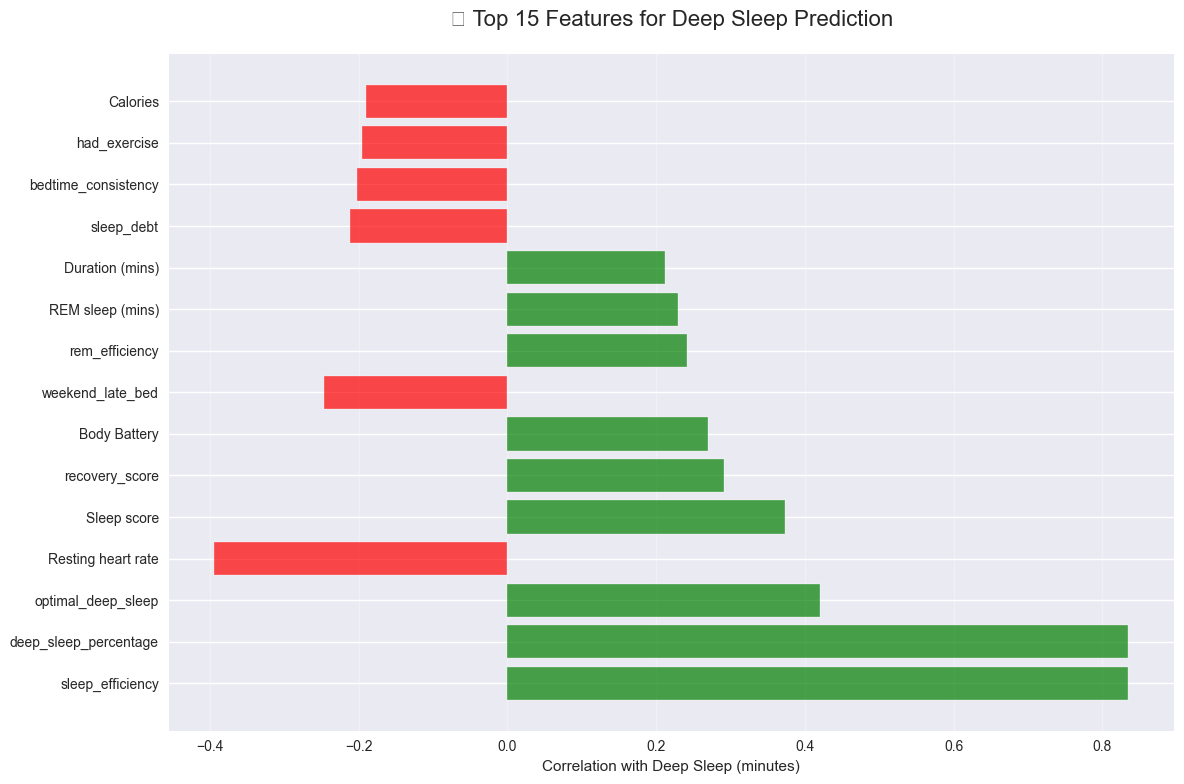

In [25]:
# =============================================================================
# 10. FEATURE IMPORTANCE FOR DEEP SLEEP PREDICTION
# =============================================================================

def analyze_feature_importance(df_final):
    """Analyze feature importance for deep sleep prediction"""

    print("\n🎯 FEATURE IMPORTANCE FOR DEEP SLEEP PREDICTION")
    print("=" * 55)

    # Select features for modeling (exclude non-numeric and target)
    exclude_cols = [
        'Date', 'Bed-time', 'Wakeup-time', 'Last screen usage', 'Sunrise', 'Sunset',
        'bedtime_parsed', 'wakeup_parsed', 'sunset_parsed', 'sunrise_parsed',
        'weekday', 'Deep sleep (mins)'  # Target variable
    ]

    feature_cols = [col for col in df_final.columns if col not in exclude_cols and df_final[col].dtype in ['int64', 'float64']]

    # Handle missing values for correlation analysis
    df_clean = df_final[feature_cols + ['Deep sleep (mins)']].fillna(df_final[feature_cols + ['Deep sleep (mins)']].median())

    # Calculate correlations with deep sleep
    correlations = df_clean.corr()['Deep sleep (mins)'].drop('Deep sleep (mins)').sort_values(key=abs, ascending=False)

    print(f"🏆 Top 15 Features Correlated with Deep Sleep:")
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        direction = "📈" if corr > 0 else "📉"
        print(f"  {i:2d}. {direction} {feature}: {corr:.3f}")

    # Create visualization
    plt.figure(figsize=(12, 8))
    top_features = correlations.head(15)
    colors = ['green' if x > 0 else 'red' for x in top_features.values]

    plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Correlation with Deep Sleep (minutes)')
    plt.title('🎯 Top 15 Features for Deep Sleep Prediction', fontsize=16, pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return correlations, feature_cols

correlations, feature_cols = analyze_feature_importance(df_final)

In [26]:
# =============================================================================
# 11. SAVE ENGINEERED FEATURES
# =============================================================================

print(f"\n💾 FEATURE ENGINEERING COMPLETE!")
print("=" * 40)
print(f"✅ Created {len(new_features)} new features")
print(f"📊 Dataset ready for modeling with {len(feature_cols)} features")
print(f"🎯 Target: Deep sleep duration (minutes)")

# Display basic statistics
print(f"\n📈 Deep Sleep Statistics (Final Dataset):")
print(f"  Mean: {df_final['Deep sleep (mins)'].mean():.1f} minutes")
print(f"  Median: {df_final['Deep sleep (mins)'].median():.1f} minutes")
print(f"  Std: {df_final['Deep sleep (mins)'].std():.1f} minutes")
print(f"  Range: {df_final['Deep sleep (mins)'].min():.0f} - {df_final['Deep sleep (mins)'].max():.0f} minutes")

# Save the engineered dataset
df_final.to_csv('engineered_features_deep_sleep.csv', index=False)
print(f"\n💾 Engineered dataset saved as 'engineered_features_deep_sleep.csv'")

print(f"\n🚀 Ready for model training! Use the feature_cols list for your predictors.")
print(f"Feature columns available in 'feature_cols' variable ({len(feature_cols)} features)")


💾 FEATURE ENGINEERING COMPLETE!
✅ Created 46 new features
📊 Dataset ready for modeling with 63 features
🎯 Target: Deep sleep duration (minutes)

📈 Deep Sleep Statistics (Final Dataset):
  Mean: 66.6 minutes
  Median: 65.0 minutes
  Std: 22.0 minutes
  Range: 22 - 148 minutes

💾 Engineered dataset saved as 'engineered_features_deep_sleep.csv'

🚀 Ready for model training! Use the feature_cols list for your predictors.
Feature columns available in 'feature_cols' variable (63 features)
